In [1]:
%pip install h5py shortprint matplotlib numpy pandas seaborn tqdm --quiet

^C
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\Documents\irradiance\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
# autoreload notebook
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm

sys.path.append("..")

from src.data import load_data
from src.config import DATA_FOLDER, RAW_DATA_PERIOD

In [4]:
# CONFIG
YEAR = 2020

# Data visualisation

## Shape of the data

(35136, 386, 371)


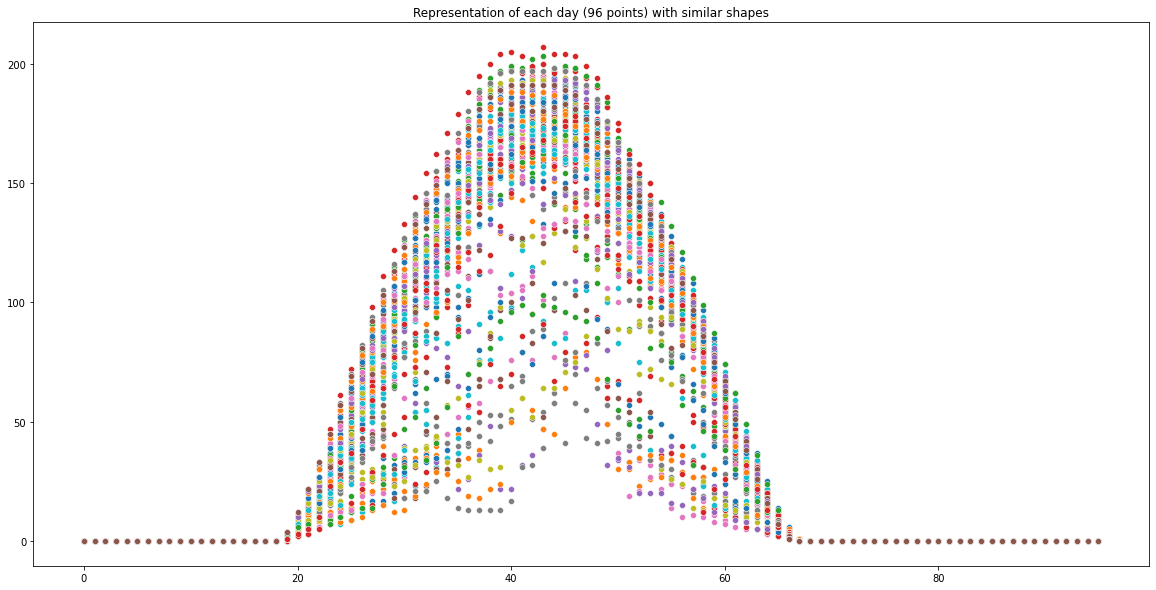

In [5]:
values = load_data(DATA_FOLDER, YEAR)
print(values.shape)
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Representation of each day (96 points) with similar shapes")
for i in range(0, values.shape[0], RAW_DATA_PERIOD):
    sns.scatterplot(x=list(range(RAW_DATA_PERIOD)),y=values[i:i+RAW_DATA_PERIOD,200,200],ax=ax);
    if i>10000:
        break

plt.savefig('../docs/overlap_days.png')

In [8]:
def compute_metrics_for_one_location_time(values, day_index: int, loc_x:int, loc_y: int, periode: int = 96):
    """Compute the metrics for one period."""
    metrics = {}
    data = values[day_index*periode:(day_index+1)*periode,loc_x, loc_y]
    metrics['min'] = float(np.min(data))
    metrics['max'] = float(np.max(data))
    metrics['q1'] = np.quantile(data, 0.25)
    metrics['mediane'] = np.quantile(data, 0.5)
    metrics['mean'] = np.mean(data)
    metrics['q3'] = np.quantile(data, 0.75)
    return metrics

In [9]:
def compute_data_one_location(values, loc_x: int, loc_y: int):
    """compute the data/metrics for one location."""
    location_data = values[:,loc_x, loc_y]
    day_data = location_data.reshape((-1, RAW_DATA_PERIOD))
    return pd.DataFrame({
        "mean": day_data.mean(axis=1),
        "min": day_data.min(axis=1),
        "max": day_data.max(axis=1),
        "q1": np.quantile(day_data, 0.25),
        "mediane": np.quantile(day_data, 0.5),
        "q3": np.quantile(day_data, 0.75),
    })


compute_data_one_location(values, 200, 200)

,mean,min,max,q1,mediane,q3
0,46.885417,0,173,0.0,0.0,83.0
1,32.239583,0,151,0.0,0.0,83.0
2,40.500000,0,154,0.0,0.0,83.0
3,40.333333,0,161,0.0,0.0,83.0
4,41.968750,0,160,0.0,0.0,83.0
...,...,...,...,...,...,...
361,43.572917,0,175,0.0,0.0,83.0
362,45.239583,0,167,0.0,0.0,83.0
363,44.458333,0,159,0.0,0.0,83.0
364,39.885417,0,156,0.0,0.0,83.0


In [10]:
saison_seche_mask = np.zeros(365, dtype=bool)
def compute_seche_period(values):
    global saison_seche_mask
    x = values.shape[0]//96
    quart = int(x/4)
    saison_seche_mask = np.zeros(x, dtype=bool)
    saison_seche_mask[quart*1:quart*3] = True


METRICS = {
    "total_max": {"function": lambda df: df["max"].max(), "title": "Max per location"},
    "max_ampli": {
        "function": lambda df: df["max"].max() - df["max"].min(),
        "title": "Max day irradiance amplitude over one year",
    },
    "max_mean": {
        "function": lambda df: df["max"].mean(),
        "title": "Max day irradiance mean over the year",
    },
    "max_std": {
        "function": lambda df: df["max"].std(),
        "title": "Max day irradiance std over the year",
    },
}
METRICS[f"dry_max"] = {
    "function": lambda df: df["max"][saison_seche_mask].max(),
    "title": f"Max day irradiance dry season",
}
METRICS[f"dry_ampli"] = {
    "function": lambda df: df["max"][saison_seche_mask].max() - df["max"][saison_seche_mask].min(),
    "title": f"Amplitude day irradiance dry season",
}
METRICS[f"dry_mean"] = {
    "function": lambda df: df["max"][saison_seche_mask].mean(),
    "title": f"Mean day irradiance dry season",
}
METRICS[f"dry_std"] = {
    "function": lambda df: df["max"][saison_seche_mask].std(),
    "title": f"Std day irradiance dry season",
}


METRICS[f"wet_max"] = {
    "function": lambda df: df["max"][~saison_seche_mask].max(),
    "title": f"Max day irradiance wet season",
}
METRICS[f"wet_ampli"] = {
    "function": lambda df: df["max"][~saison_seche_mask].max() - df["max"][~saison_seche_mask].min(),
    "title": f"Amplitude day irradiance wet season",
}
METRICS[f"wet_mean"] = {
    "function": lambda df: df["max"][~saison_seche_mask].mean(),
    "title": f"Mean day irradiance wet season",
}
METRICS[f"wet_std"] = {
    "function": lambda df: df["max"][~saison_seche_mask].std(),
    "title": f"Std day irradiance wet season",
}


METRICS["ecart_wet_dry"] = {
    "function": lambda df: df["max"][saison_seche_mask].mean() - df["max"][~saison_seche_mask].mean(),
    "title": f"Irradiance diff between wet and dry season",
}

In [11]:
def compute_data_all_locations(year: int, size: int = 20):
    """compute the data/metrics for all locations."""
    values = load_data(DATA_FOLDER, year)
    compute_seche_period(values)

    result_matrices = {key: np.zeros(values.shape[1:]) for key in METRICS.keys()}

    # compute the data
    total = int(values.shape[1] * values.shape[2] / size / size)
    with tqdm(total=total) as pbar:
        for x in range(0, values.shape[1], size):
            for y in range(0, values.shape[2], size):
                location_data = compute_data_one_location(values, x, y)
                for key, metric in METRICS.items():
                    result_matrices[key][x:x+size, y:y+size] = metric["function"](location_data)
                pbar.update(1)

    return result_matrices


In [69]:
from pathlib import Path

def plot_graphics(result_matrices, cmap="OrRd", year: int = 2020):
    """Plot all the graphics."""
    folder = f"../docs/{year}/"
    
    path = Path(folder)
    path.mkdir(parents=True, exist_ok=True)
    for metric_name, metric_data in METRICS.items():
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_title(metric_data['title'])
        sns.heatmap(result_matrices[metric_name], cmap=cmap, ax=ax)
        plt.savefig(os.path.join(folder, f"{metric_name}.png"))
        



In [72]:
result_matrices = compute_data_all_locations(year=2020, size=1)

100%|██████████| 143206/143206 [12:11<00:00, 195.81it/s]


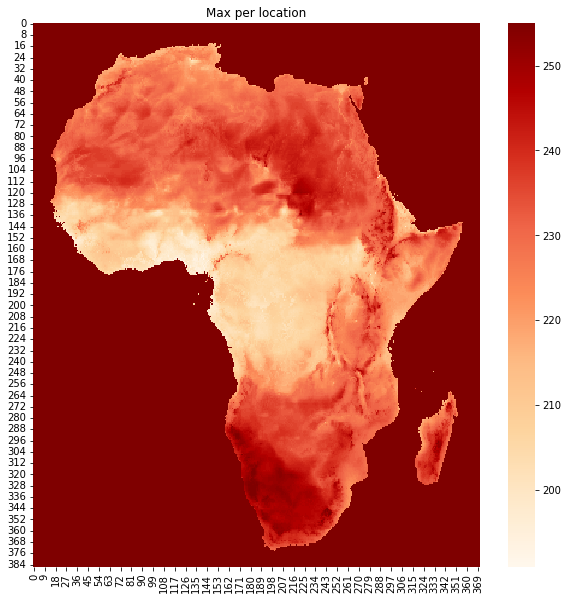

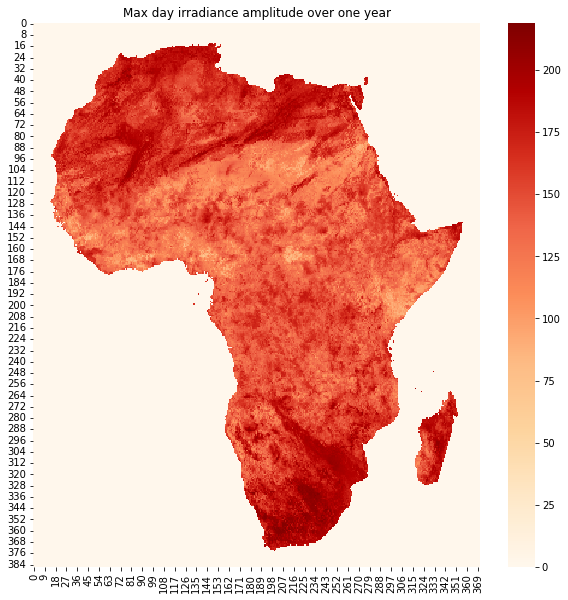

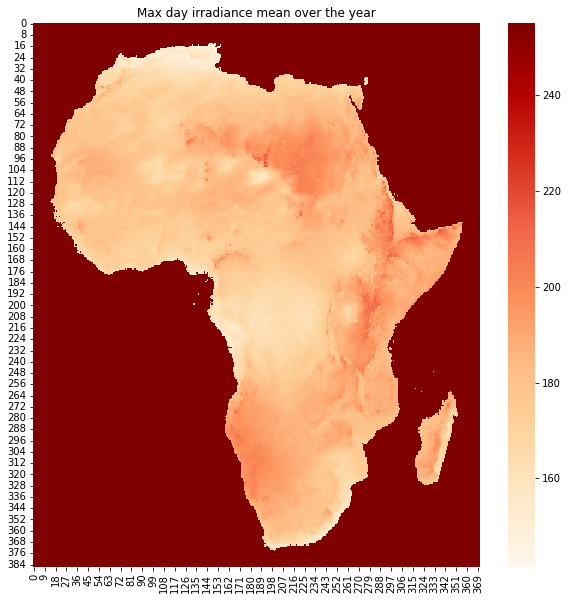

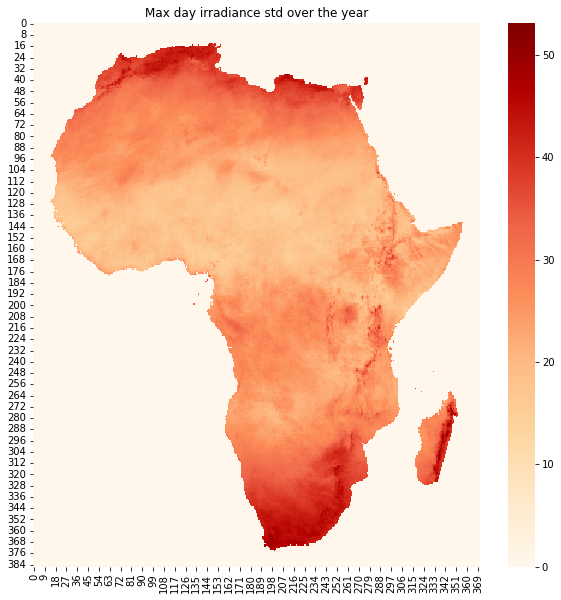

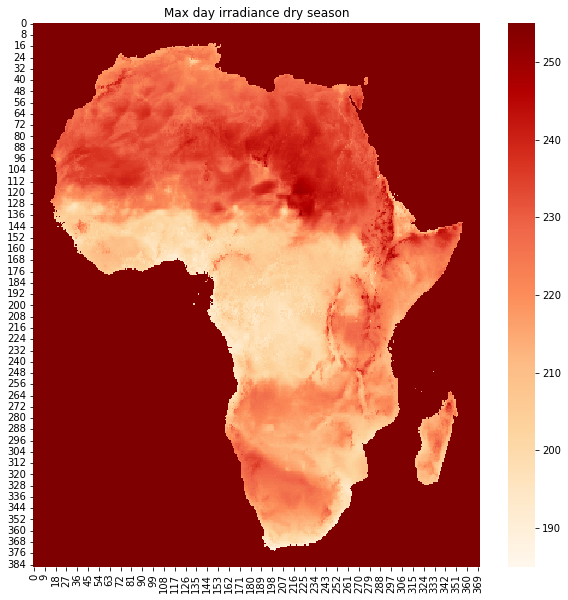

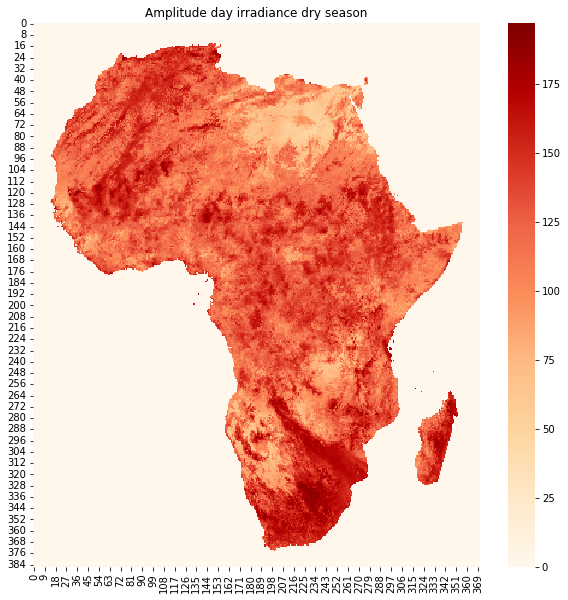

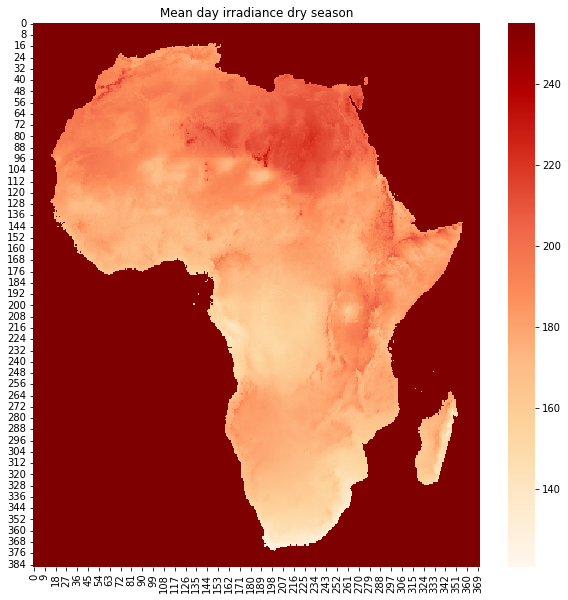

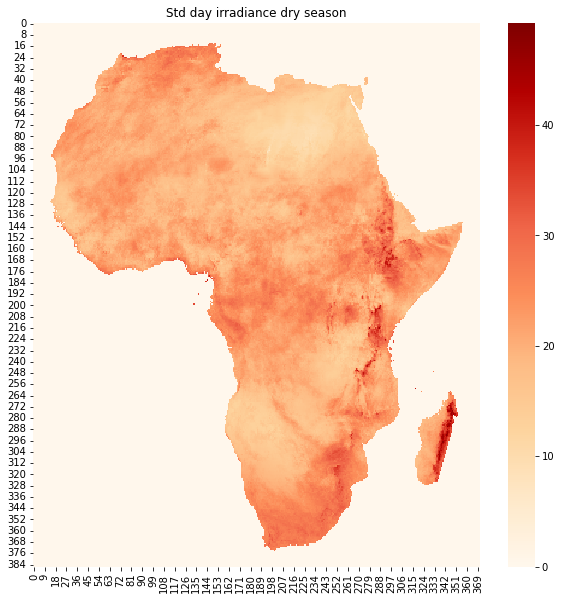

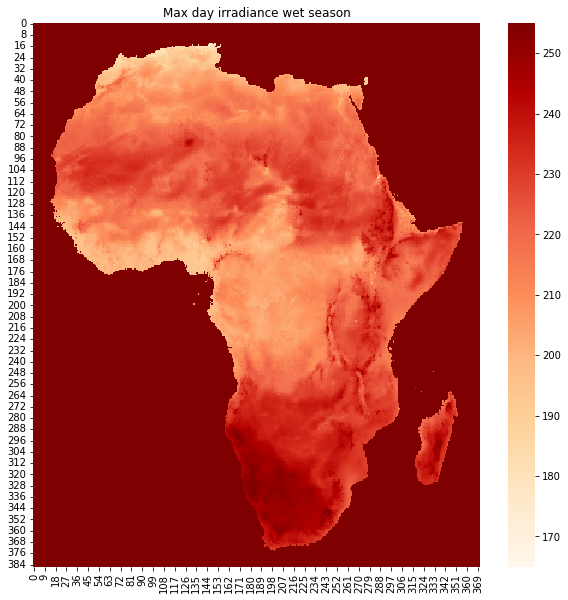

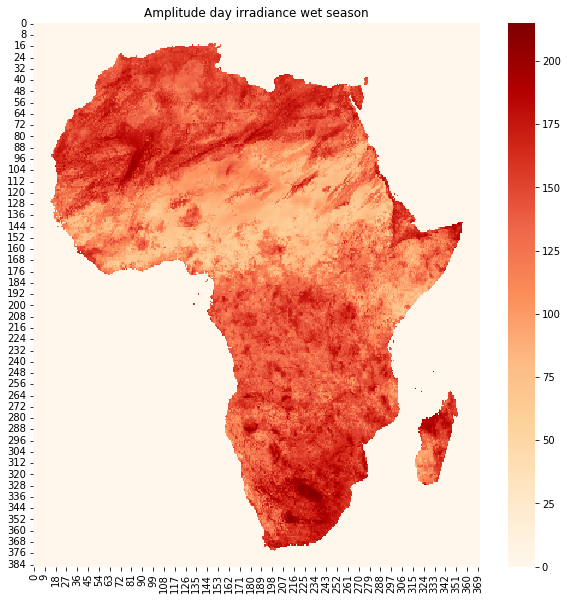

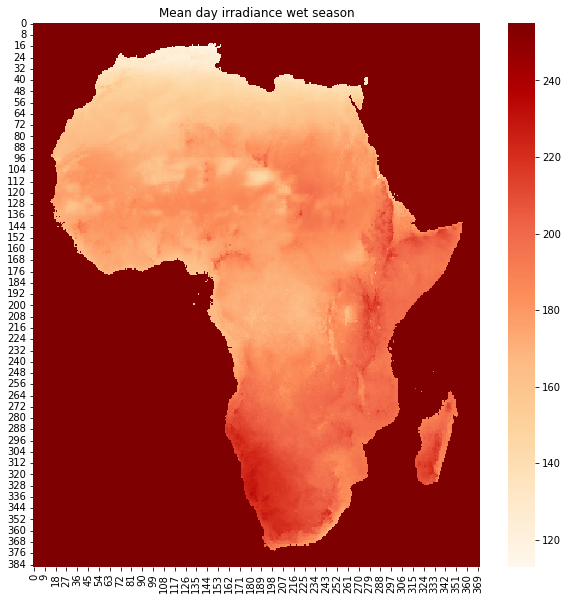

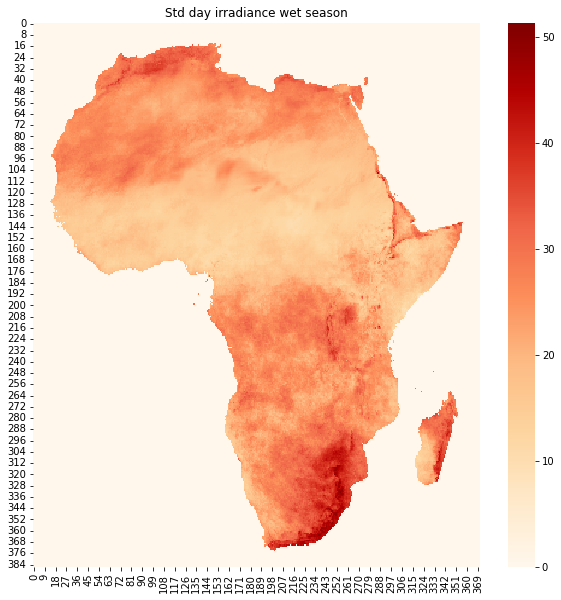

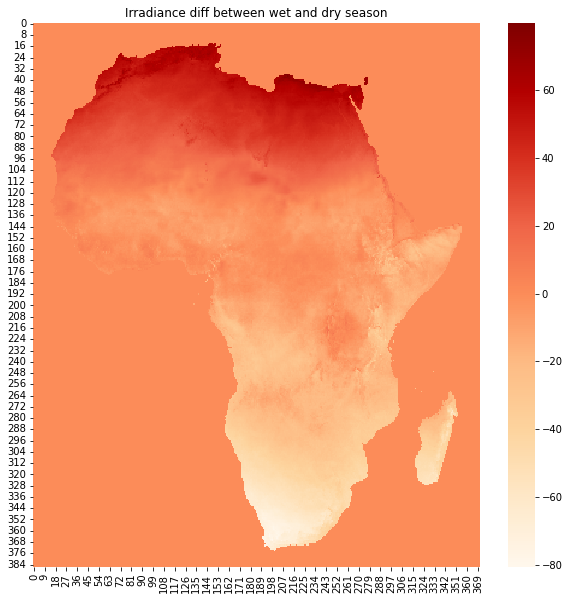

In [73]:
plot_graphics(result_matrices, cmap="OrRd", year=2020)

In [6]:
import os
from tqdm import tqdm
folder = "../images/day_timelapse"
os.makedirs(folder, exist_ok=True)
for i in tqdm(range(96*3)):
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    sns.heatmap(values[i], ax=ax, cmap="OrRd")
    plt.savefig(os.path.join(folder, f"{str(i).rjust(5,'0')}.png"))
    plt.close()

100%|██████████| 288/288 [03:20<00:00,  1.44it/s]


In [7]:
#https://stackoverflow.com/a/57751793
import glob
from PIL import Image

# filepaths
fp_in = "../images/day_timelapse/*.png"
fp_out = "../docs/day_timelapse.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=100, loop=0)

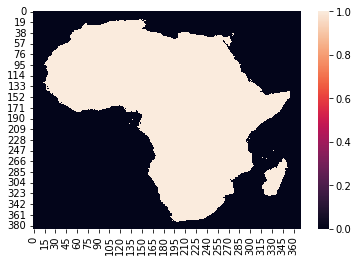

In [14]:
import os, sys
import seaborn as sns
sys.path.append('..')
from src.data import load_data
from src.config import DATA_FOLDER

def get_africa_mask():
    """Get africa mask (no oceans)."""
    data = load_data(DATA_FOLDER, 2020)[6] == 0
    return data

mask = get_africa_mask()
sns.heatmap(mask);